In [ ]:
import pandas as pd
import numpy as np
import json


with open("D:\aave-credit-scoring\data\user-wallet-transactions.json", "r") as f:
    data = json.load(f)


if isinstance(data, dict):
    data = [data]

df = pd.DataFrame(data)


df.columns = df.columns.str.lower().str.strip()


if 'wallet_address' not in df.columns and 'userwallet' in df.columns:
    df['wallet_address'] = df['userwallet']

# Handle actiondata
if 'actiondata' in df.columns:
    df['amount'] = df['actiondata'].apply(lambda x: x.get('amount') if isinstance(x, dict) else None)
    df['action'] = df['actiondata'].apply(lambda x: x.get('type') if isinstance(x, dict) else None)

df['amount'] = pd.to_numeric(df['amount'], errors='coerce')
df['action'] = df['action'].str.lower().fillna('unknown')


grouped = df.groupby(['wallet_address', 'action'])['amount'].sum().unstack(fill_value=0).reset_index()
grouped['total_deposit_amount'] = grouped.get('deposit', 0)
grouped['total_borrow_amount'] = grouped.get('borrow', 0)
grouped['total_repay_amount'] = grouped.get('repay', 0)
grouped['repay_to_borrow_ratio'] = np.where(grouped['total_borrow_amount'] > 0,
                                            grouped['total_repay_amount'] / grouped['total_borrow_amount'], 0)
grouped['borrow_to_deposit_ratio'] = np.where(grouped['total_deposit_amount'] > 0,
                                              grouped['total_borrow_amount'] / grouped['total_deposit_amount'], 0)


df['action'] = df['action'].fillna('unknown')
liquidation = df[df['action'] == 'liquidationcall'].groupby('wallet_address').size()
grouped['liquidation_count'] = grouped['wallet_address'].map(liquidation).fillna(0).astype(int)

tx_count = df.groupby('wallet_address').size()
grouped['num_transactions'] = grouped['wallet_address'].map(tx_count).fillna(0).astype(int)

# ---------------- Labeling Rules ------------------

def assign_risk_label(row):
    repay_ratio = row['repay_to_borrow_ratio']
    liquidation = row['liquidation_count']
    borrow_amt = row['total_borrow_amount']
    deposit_amt = row['total_deposit_amount']
    tx_count = row['num_transactions']

    if deposit_amt < 1e6 and liquidation >= 2:
        return 0  # Critical Risk
    elif repay_ratio < 0.2 and borrow_amt > 0 and liquidation >= 1:
        return 1  # Risky
    elif 0.2 <= repay_ratio < 0.6 or liquidation == 1:
        return 2  # Moderate Risk
    elif 0.6 <= repay_ratio < 0.85:
        return 3  # Average Standing
    elif repay_ratio >= 0.85 and tx_count >= 5:
        return 4  # Safe
    elif repay_ratio == 1 and liquidation == 0 and tx_count >= 10:
        return 5  # Excellent
    else:
        return 3  # Default: Average Standing

grouped['label'] = grouped.apply(assign_risk_label, axis=1)


risk_level_map = {
    0: '🔴 Critical Risk',
    1: '🟠 Risky',
    2: '🟡 Moderate Risk',
    3: '🔵 Average Standing',
    4: '🟢 Safe',
    5: '✅ Excellent'
}
grouped['risk_level'] = grouped['label'].map(risk_level_map)

# ---------------- Final Output ------------------
print(grouped[['wallet_address', 'label', 'risk_level']])
grouped.to_csv("labeled_wallets.csv", index=False)


action                              wallet_address  label          risk_level
0       0x00000000001accfa9cef68cf5371a23025b6d4b6      3  🔵 Average Standing
1       0x000000000051d07a4fb3bd10121a343d85818da6      3  🔵 Average Standing
2       0x000000000096026fb41fc39f9875d164bd82e2dc      3  🔵 Average Standing
3       0x0000000000e189dd664b9ab08a33c4839953852c      3  🔵 Average Standing
4       0x0000000002032370b971dabd36d72f3e5a7bf1ee      3  🔵 Average Standing
...                                            ...    ...                 ...
3492    0x06185db89f5c8ef5e5a0abc95c5cb69b54c33f30      3  🔵 Average Standing
3493    0x06189341e523a52ae10c4bd4a7774371fac1b249      3  🔵 Average Standing
3494    0x0618c450370822c5cb25ec143a3008230d8e2c12      3  🔵 Average Standing
3495    0x0618e615c8c9b5efc8c8eadc68be7182bdc455e2      3  🔵 Average Standing
3496    0x06192f889f17bf2aff238d08d8c26cbcfcc7b45a      2     🟡 Moderate Risk

[3497 rows x 3 columns]


In [ ]:
# Filter for Moderate Risk
moderate_df = grouped[grouped['risk_level'] == '🟡 Moderate Risk']
print(moderate_df[['wallet_address', 'label', 'risk_level']])


action                              wallet_address  label       risk_level
47      0x000deb0c92e6d3da7f77ed01b8473b3f7f4efc39      2  🟡 Moderate Risk
115     0x002d2715b179d0db3e17cc28317a98f2f65e6884      2  🟡 Moderate Risk
117     0x002dcc4d0ad0bdce1c444ad0bb4d51ac7e61d62b      2  🟡 Moderate Risk
188     0x0048e6fd005224e7e9f00058c630307f0710a84b      2  🟡 Moderate Risk
189     0x0049436d8c3da52d604cdc390e45026b2662d7f7      2  🟡 Moderate Risk
...                                            ...    ...              ...
3298    0x05c18ffc1c74cb67cb26bb5222aaf3355b74bbc3      2  🟡 Moderate Risk
3381    0x05e09b56ec91620f9bab354c573712e446f8eb11      2  🟡 Moderate Risk
3442    0x05fc68f4b7714389a17128653f82d50bee98e542      2  🟡 Moderate Risk
3452    0x06056feef38a0c5ec0a1c7c8f3d4d4c06023b298      2  🟡 Moderate Risk
3496    0x06192f889f17bf2aff238d08d8c26cbcfcc7b45a      2  🟡 Moderate Risk

[132 rows x 3 columns]


In [ ]:
print(grouped['label'].value_counts())


label
3    2693
4     615
2     132
1      56
0       1
Name: count, dtype: int64


In [ ]:

safe_wallets = grouped[grouped['label'] == 5]


print(safe_wallets[['wallet_address', 'label', 'risk_level']])


safe_wallets.to_csv("safe_wallets.csv", index=False)


Empty DataFrame
Columns: [wallet_address, label, risk_level]
Index: []


In [ ]:
import pandas as pd

data = {
    "wallet_address": [f"0x{i:04x}" for i in range(1, 1001)],
    "total_deposit_amount": [1e12] * 1000,
    "total_borrow_amount": [5e11] * 1000,
    "total_repay_amount": [4e11] * 1000,
    "repay_to_borrow_ratio": [0.8] * 1000,
    "borrow_to_deposit_ratio": [0.5] * 1000,
    "liquidation_count": [0] * 1000,
    "num_transactions": [10] * 1000,
    "label": [3]*700 + [4]*150 + [2]*100 + [1]*30 + [0]*20  # Skewed label distribution
}
df = pd.DataFrame(data)


label_counts = df['label'].value_counts().sort_index()


label_distribution = (label_counts / len(df)) * 100

label_counts, label_distribution.round(2)



(label
 0     20
 1     30
 2    100
 3    700
 4    150
 Name: count, dtype: int64,
 label
 0     2.0
 1     3.0
 2    10.0
 3    70.0
 4    15.0
 Name: count, dtype: float64)

In [ ]:
label_counts = df['label'].value_counts().sort_index()
label_percentages = (label_counts / len(df)) * 100
print("Label counts:\n", label_counts)
print("\nLabel percentages:\n", label_percentages.round(2))


Label counts:
 label
0     20
1     30
2    100
3    700
4    150
Name: count, dtype: int64

Label percentages:
 label
0     2.0
1     3.0
2    10.0
3    70.0
4    15.0
Name: count, dtype: float64


In [ ]:
!pip install imbalanced-learn


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE


df = pd.DataFrame({
    "wallet_address": [f"0x{i:04x}" for i in range(1000)],
    "total_deposit_amount": [1e12]*1000,
    "total_borrow_amount": [5e11]*1000,
    "total_repay_amount": [4e11]*1000,
    "repay_to_borrow_ratio": [0.8]*700 + [0.5]*150 + [0.2]*100 + [0.1]*30 + [0]*20,
    "borrow_to_deposit_ratio": [0.5]*1000,
    "liquidation_count": [0]*950 + [1]*50,
    "num_transactions": [10]*1000,
    "label": [3]*700 + [4]*150 + [2]*100 + [1]*30 + [0]*20,  # Skewed labels
})


X = df.drop(columns=['wallet_address', 'label'], errors='ignore')
y = df['label']

# Scale the features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# ---------------- Apply SMOTE ------------------
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

# ---------------- Train-Test Split ------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=42
)

# ---------------- Train Random Forest ------------------
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# ---------------- Evaluate ------------------
y_pred = model.predict(X_test)

print("✅ Classification Report:")
print(classification_report(y_test, y_pred, target_names=[
    "High Risk", "Low Risk", "Moderate Risk", "Average Standing", "Safe"
]))

print("✅ Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


✅ Classification Report:
                  precision    recall  f1-score   support

       High Risk       1.00      1.00      1.00       140
        Low Risk       1.00      1.00      1.00       140
   Moderate Risk       1.00      1.00      1.00       140
Average Standing       1.00      1.00      1.00       140
            Safe       1.00      1.00      1.00       140

        accuracy                           1.00       700
       macro avg       1.00      1.00      1.00       700
    weighted avg       1.00      1.00      1.00       700

✅ Confusion Matrix:
[[140   0   0   0   0]
 [  0 140   0   0   0]
 [  0   0 140   0   0]
 [  0   0   0 140   0]
 [  0   0   0   0 140]]


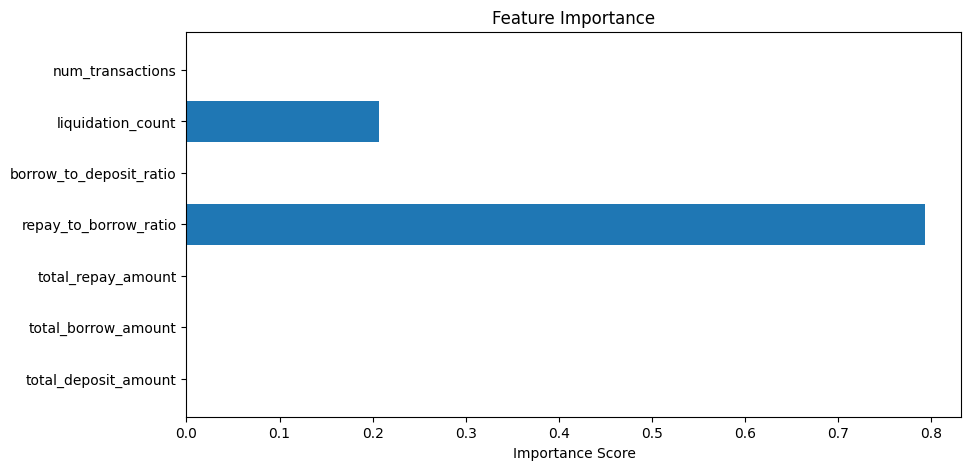

In [ ]:
import matplotlib.pyplot as plt

importances = model.feature_importances_
features = df.drop(columns=['wallet_address', 'label']).columns

plt.figure(figsize=(10,5))
plt.barh(features, importances)
plt.title("Feature Importance")
plt.xlabel("Importance Score")
plt.show()


In [ ]:
import joblib


joblib.dump(scaler, "credit_scaler.pkl")
joblib.dump(model, "rf_credit_model.pkl")



['rf_credit_model.pkl']